In [2]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm
import random 

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

import matplotlib.pyplot as plt
import gym

In [34]:
env = gym.make('Roulette-v0')
env.nA = 38

In [37]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = (np.zeros(env.nA) + epsilon) / env.nA
        
        if np.count_nonzero(Q[observation]) == 0:
            best = np.random.choice(range(env.nA))
        else:
            best = np.argmax(Q[observation])
        
        A[best] += (1.0 - epsilon)
        
        return A
        
    return policy_fn

def make_epsilon_greedy_double_q_policy(Q1, Q2, epsilon, nA):
    
    def policy_fn(observation):
        
        Q_add = defaultdict(lambda: np.zeros(env.nA))
    
        for key1, value1 in Q1.items():
        
            for key2, value2 in Q2.items():
            
                if key1 == key2:
                
                    Q_add[key1] = value1 + value2
        
        A = (np.zeros(env.nA) + epsilon) / env.nA

        if np.count_nonzero(Q_add[observation]) == 0:
            best = np.random.choice(range(env.nA))
        else:
            best = np.argmax(Q_add[observation])
        
        A[best] += (1.0 - epsilon)
        return A
        
    return policy_fn

In [38]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Keeps track of useful statistics
    stats = []
    action_left = 0

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    for i_episode in range(num_episodes):
        #i = 0
        R = 0

        current_state = env.reset()
        action_probs = policy(current_state) 
        current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        episode_lenghts = 0

        while True:
            
            next_state, reward, done, _ = env.step(current_action)
            episode_lenghts += 1
            if done:
                break
            
            next_A = policy(next_state)

            next_action = np.random.choice(range(env.nA), p=next_A)
            
            target = reward + (discount_factor * max(Q[next_state]) - Q[current_state][current_action])
            Q[current_state][current_action] += alpha * target
            
            #i += 1
            R += reward
            
            current_state, current_action = next_state, next_action

        stats.append(episode_lenghts)
    return Q, stats

In [39]:
RUNS = 100
EPISODES = 300

q_data = np.zeros((RUNS, EPISODES))

for i in tqdm(range(RUNS)):
    _, stats = q_learning(env, EPISODES)
    q_data[i, :] = stats

100%|██████████| 100/100 [05:31<00:00,  3.49s/it]


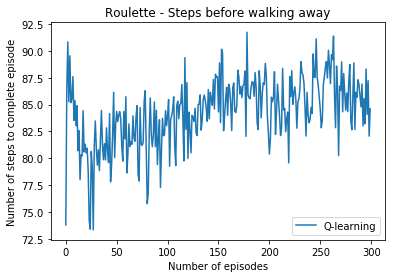

In [41]:
# Plot percentage actions left over episodes:
plt.plot(q_data.mean(0), label='Q-learning')
#plt.plot(dq_data.mean(0), label='Double Q-learning')
plt.title('Roulette - Steps before walking away')
plt.xlabel('Number of episodes')
plt.ylabel('Number of steps to complete episode')
#plt.gca().set_ylim([0,300])
plt.legend()
plt.show()

In [42]:
def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1, Q1=None, Q2=None):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
        
    if Q1 is None:
        Q1 = defaultdict(lambda: np.zeros(env.nA))
    if Q2 is None:
        Q2 = defaultdict(lambda: np.zeros(env.nA))
    
    # Keeps track of useful statistics
    stats = []
    action_left = 0

    # The policy we're following    
    policy = make_epsilon_greedy_double_q_policy(Q1, Q2, epsilon, env.nA)
    
    #Keep track of which update function we use, we alternate between 1/2
    turn1 = random.choice([True, False])
    
    for i_episode in range(num_episodes):
        R = 0
        current_state = env.reset()
        action_probs = policy(current_state) 
        current_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        if current_action == 0:
            action_left += 1
            
        done = False
        episode_lenghts = 0

        while True:
            
            next_state, reward, done, _ = env.step(current_action)
            episode_lenghts += 1
            
            if done:
                break
            
            next_A = policy(next_state)
            next_action = np.random.choice(range(env.nA), p=next_A)
            
            if turn1:
                target = reward + discount_factor * (Q2[next_state][np.argmax(Q1[next_state])] - Q1[current_state][current_action])
                Q1[current_state][current_action] += alpha * target
            else:
                target = reward + discount_factor * (Q1[next_state][np.argmax(Q2[next_state])] - Q2[current_state][current_action])
                Q2[current_state][current_action] += alpha * target
                
            R += reward
            
            current_state, current_action = next_state, next_action
            
            #Switch turns
            turn1 = random.choice([True, False])
    
        stats.append(episode_lenghts)
        
    return Q1, Q2, stats

In [44]:
RUNS = 100
EPISODES = 300

dq_data = np.zeros((RUNS, EPISODES))

for i in tqdm(range(RUNS)):
    _,_, stats = double_q_learning(env, EPISODES)
    dq_data[i, :] = stats

100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


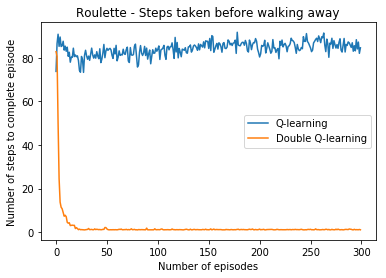

In [46]:
# Plot percentage actions left over episodes:
plt.plot(q_data.mean(0), label='Q-learning')
plt.plot(dq_data.mean(0), label='Double Q-learning')
plt.title('Roulette - Steps taken before walking away')
plt.xlabel('Number of episodes')
plt.ylabel('Number of steps to complete episode')
plt.legend()
plt.show()